In [1]:
import timeit

start = timeit.default_timer()

In [2]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import fiona
import wget
import rasterio
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import glob
import zipfile
import time
#from datetime import datetime, timedelta
import datetime

import rioxarray
from rasterio import plot
from rasterio import mask
from rasterio.mask import mask
import xarray 
from pathlib import Path
import matplotlib.pyplot as plt

import re
import requests
#pd.set_option('display.max_columns', None)
#pd.set_option('max_colwidth', None)

from osgeo import gdal, osr
from rasterio.warp import reproject, Resampling


from shapely.geometry import Polygon

# Creating and plotting the flowchart libs:
import pygraphviz as pgv
from PIL import Image

# Library used to get all folders in a given directory
# It is used in the removal process
import shutil

# stop warning:
import warnings
warnings.filterwarnings("ignore")

import math
# adding a background map
import contextily as ctx

from tqdm import tqdm

C:\Users\G\anaconda3\envs\env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


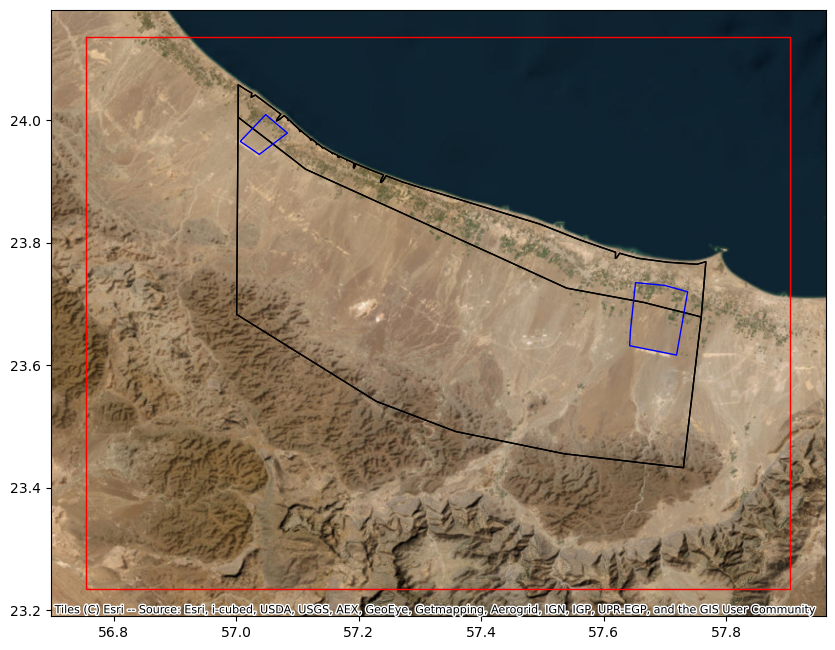

In [3]:
# Importing the area of interest
aoi = gpd.read_file("./shapefiles/area_of_intrest.shp")

# Transform to WGS84
aoi_wgs = aoi.to_crs('EPSG:4326')

In [4]:
# creating sentinel api
api = SentinelAPI('UserName','Password','https://apihub.copernicus.eu/apihub/')

In [7]:
# create a footprint of the data
footprint = None
for i in aoi_s_wgs['geometry']:
    footprint = i


# entering the required start date
start_date = '2019-01-01'

# entering the end date
end_date = '2023-04-10'

# changing the dates format
api_start = start_date.translate( { ord("-"): None } )
api_end = end_date.translate( { ord("-"): None } )

# extrating the all available products:
satellite_data = api.query(
    footprint,
    date =(api_start, api_end),
    platformname = 'Sentinel-2',
    processinglevel = 'Level-2A',
    cloudcoverpercentage = (0,10))

Querying products: 100%|██████████| 1029/1029 [00:16<00:00, 55.79product/s]


In [8]:
# convering the results to a geodataframe for further filtration 
products = api.to_geodataframe(satellite_data)

# 
products_aoi = products[products['filename'].str.contains("R120_T40QEM")]
products_aoi = products_aoi[products_aoi['platformserialidentifier'] == 'Sentinel-2A']
products_aoi['date'] = pd.to_datetime(products_aoi['beginposition']).dt.date

In [9]:
# extrating the products dates to a list
dates_list = pd.to_datetime(products_aoi['beginposition']).dt.date.tolist()

# using the input dates, generate dates that are 3 months apart:
required_dates = pd.date_range(start_date,
                    end_date,
                    freq='10d').strftime('%Y-%m-%d').tolist()



In [10]:
# format the dates 
formulated_dates =[]
for date in required_dates:
    try:
        read = datetime.datetime.strptime(date,'%Y-%m-%d').date()
        formulated_dates.append(read)
    except ValueError:
        print("ValueError in: ")
        print(date)

In [11]:
# selecting the dates in the products df that are nearest to the dates of the entered dates.
selected_dates = []
for date in formulated_dates:
    selected_dates.append(min(dates_list , key=lambda sub: abs(sub - date)))
selected_dates = list(set(selected_dates))
selected_dates.sort()
selected_dates

[datetime.date(2019, 1, 1),
 datetime.date(2019, 1, 31),
 datetime.date(2019, 2, 10),
 datetime.date(2019, 3, 12),
 datetime.date(2019, 4, 21),
 datetime.date(2019, 5, 1),
 datetime.date(2019, 5, 11),
 datetime.date(2019, 5, 31),
 datetime.date(2019, 6, 10),
 datetime.date(2019, 6, 20),
 datetime.date(2019, 6, 30),
 datetime.date(2019, 7, 20),
 datetime.date(2019, 8, 19),
 datetime.date(2019, 9, 18),
 datetime.date(2019, 9, 28),
 datetime.date(2019, 10, 8),
 datetime.date(2019, 10, 18),
 datetime.date(2019, 10, 28),
 datetime.date(2019, 11, 7),
 datetime.date(2020, 1, 6),
 datetime.date(2020, 1, 16),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 15),
 datetime.date(2020, 2, 25),
 datetime.date(2020, 3, 6),
 datetime.date(2020, 3, 26),
 datetime.date(2020, 4, 25),
 datetime.date(2020, 5, 5),
 datetime.date(2020, 5, 15),
 datetime.date(2020, 5, 25),
 datetime.date(2020, 6, 4),
 datetime.date(2020, 6, 24),
 datetime.date(2020, 7, 14),
 datetime.date(2020

In [12]:
# extracting the data based on the dates:
scenes = products_aoi[products_aoi['date'].isin(selected_dates)].to_dict('records')
scenes

[{'title': 'S2A_MSIL2A_20230331T063621_N0509_R120_T40QEM_20230331T095859',
  'link': "https://apihub.copernicus.eu/apihub/odata/v1/Products('81fef3cd-3f7c-4ea5-82db-110a32fe6a7a')/$value",
  'link_alternative': "https://apihub.copernicus.eu/apihub/odata/v1/Products('81fef3cd-3f7c-4ea5-82db-110a32fe6a7a')/",
  'link_icon': "https://apihub.copernicus.eu/apihub/odata/v1/Products('81fef3cd-3f7c-4ea5-82db-110a32fe6a7a')/Products('Quicklook')/$value",
  'summary': 'Date: 2023-03-31T06:36:21.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 934.42 MB',
  'ondemand': 'false',
  'generationdate': Timestamp('2023-03-31 09:58:59'),
  'beginposition': Timestamp('2023-03-31 06:36:21.024000'),
  'endposition': Timestamp('2023-03-31 06:36:21.024000'),
  'ingestiondate': Timestamp('2023-03-31 12:15:15.559000'),
  'orbitnumber': 40586,
  'relativeorbitnumber': 120,
  'illuminationazimuthangle': 132.210788869321,
  'illuminationzenithangle': 27.8795809757685,
  'vegetationpercentage': 1.110882,
  'not

In [13]:
# create a downloads file in the path, if it does not exist
download_dir = os.path.join(os.getcwd() , 'downloads')
os.makedirs(download_dir, exist_ok=True)


In [14]:
# les that are part of the current analysis:
files_to_delete = [scene['title'] + ext for scene in scenes for ext in ['.zip', '.SAFE']]


def delete_files_and_folders_not_in_list(file_list):    
    # Get a list of all files and folders in the directory
    all_items = os.listdir(download_dir)
    
    # Iterate over each item in the directory
    for item_name in all_items:
        # Create the item path
        item_path = os.path.join(download_dir, item_name)
        
        # Check if the item is not in the provided list
        if item_name not in file_list:
            # Check if the item path is a file
            if os.path.isfile(item_path):
                # Delete the file
                os.remove(item_path)
                print(f"Deleted file: {item_path}")
            elif os.path.isdir(item_path):
                # Delete the folder and its contents
                shutil.rmtree(item_path)
                print(f"Deleted folder: {item_path}")


# Call the function to delete files not in the list
delete_files_and_folders_not_in_list(files_to_delete)

In [15]:
# Loop through each scene id and attempt to download, try twice before moving to the next one
downloaded_basenames = [os.path.basename(downloaded_file) for downloaded_file in glob.glob(os.path.join(download_dir, '**', '*.zip'), recursive=True)]
downloaded_scene_titles = {os.path.splitext(downloaded_basename)[0] for downloaded_basename in downloaded_basenames}

all_scene_titles = {scene['title'] for scene in scenes}

scene_ids = [scene['uuid'] for scene in scenes if scene['title'] in all_scene_titles.difference(downloaded_scene_titles)]
# print("[INFO] {} scenes remain to download".format(len(scene_ids)))


for idx, scene_id in enumerate(scene_ids):
    product_info = api.get_product_odata(scene_id)
    print("[INFO] Product {} ({}/{}); Online: {}".format(
        product_info['id'],
        idx + 1,
        len(scene_ids),
        product_info['Online']))
    attempts = 0
    
    while attempts < 1:
        try:
            api.download(product_info['id'], download_dir)
            break  # If successful, move past
        except Exception as e:
            print("[ERROR] Request failed.. (current time: {})".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
        attempts += 1




# update the list after the initial request to select any scenes that were not downloaded
downloaded_basenames = [os.path.basename(downloaded_file) for downloaded_file in glob.glob(os.path.join(download_dir, '**', '*.zip'), recursive=True)]
downloaded_scene_titles = {os.path.splitext(downloaded_basename)[0] for downloaded_basename in downloaded_basenames}
scene_ids = [scene['uuid'] for scene in scenes if scene['title'] in all_scene_titles.difference(downloaded_scene_titles)]

# this loop wait 30 minutes after the initial downloading so that scenes become online 
if len(scene_ids) == 0:
    print("[INFO] No more files left to download from CSV files")
else:
    print("[INFO] {} scenes remain to download".format(len(scene_ids)))
    print('[INFO] Sleeping for 31 minutes until the files are online to download (downloading will resume at: {})'.format(
                    (datetime.datetime.now() + datetime.timedelta(minutes=31)).strftime("%Y-%m-%d %H:%M") ))
    time.sleep(60 * 30)
    for idx, scene_id in enumerate(scene_ids):
        product_info = api.get_product_odata(scene_id)
        print("[INFO] Product {} ({}/{}); Online: {}".format(
            product_info['id'],
            idx + 1,
            len(scene_ids),
            product_info['Online']))
        attempts = 0
        
        while attempts < 10:
            try:
                api.download(product_info['id'], download_dir)
                break  # If successful, move past
            except Exception as e:
                wait_time = 2
                print("[ERROR] Request failed.. waiting {} seconds before retrying (current time: {})".format(
                    wait_time * 60,
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
                time.sleep(60 * wait_time)
            attempts += 1

[INFO] No more files left to download from CSV files


In [ ]:
# extracting all the downloade files:
def un_zipFiles(download_dir):
    files=os.listdir(download_dir)
    for file in files:
        if file.endswith('.zip'):
            filePath=download_dir+'/'+file
            zip_file = zipfile.ZipFile(filePath)
            for names in zip_file.namelist():
                zip_file.extract(names,download_dir)
            zip_file.close() 
            
un_zipFiles(download_dir)

In [16]:
aoi_polygons = list(aoi.geometry)
aoi_polygons

[<POLYGON ((500098.855 2619096.955, 500337.726 2654738.033, 500348.805 266061...>]

In [38]:
# this function import the band, and filter it to remove any saturated pixels
def importing_jp2_before(item,list):
    image_name = item.name.split('.')[0]
    list.append(image_name)
    xds = rioxarray.open_rasterio(os.path.join(download_dir, item))
    xds = xds.where(xds > 1, other = 1)
    xds = xds.where(xds < 10000, other = 1)
    xds = xds.rio.clip(aoi_polygons, aoi.crs, drop=True).to_dataset(name ='band_data')
    globals()[image_name] = xds

In [18]:
Band3_list = []   # Green
Band4_list = []   # Red
Band8_list = []   # NIR

# importing the required scenes and adding their names to the lists above
for item in Path(download_dir).glob('**/*10m.jp2'):
    image_date = item.name.split('_')[1].split('T')[0]
    image_date = datetime.datetime.strptime(image_date, "%Y%m%d").strftime("%Y-%m-%d")
    if item.name.endswith('B03_10m.jp2'):
        importing_jp2_before(item,Band3_list)
    if item.name.endswith('B04_10m.jp2'):
        importing_jp2_before(item,Band4_list)
    if item.name.endswith('B08_10m.jp2'):
        importing_jp2_before(item,Band8_list)

In [40]:
# si_9 = (nir*red)/green

# generating the soil salinity index 9
si_9_result = []
for index, band in enumerate(selected_dates):
    date_name = format(band.strftime('%Y%m%d'))
    file_name = "si_9_{}".format(date_name)
    band_4 = locals()[[i for i in vars() if date_name in i and 'B04' in i][0]]
    band_8 = locals()[[i for i in vars() if date_name in i and 'B08' in i][0]] 
    band_3 = locals()[[i for i in vars() if date_name in i and 'B03' in i][0]]
    if selected_dates[index] < datetime.datetime.strptime('2022-01-25', '%Y-%m-%d').date():
        results = ((band_4) * (band_8)) / (band_3)
    elif selected_dates[index] >= datetime.datetime.strptime('2022-01-25', '%Y-%m-%d').date():
        band_4_e = band_4 - 1000
        band_8_e = band_8 - 1000
        band_3_e = band_3 - 1000
        band_4_e = band_4_e.where(band_4_e['band_data'] > 1, other = 1)
        band_8_e = band_8_e.where(band_8_e['band_data'] > 1, other = 1)
        band_3_e = band_3_e.where(band_3_e['band_data'] > 1, other = 1)
        results= ((band_4_e * band_8_e) / band_3_e)
    results = results.where(results > 1, other = 1)
    results = results.where(results < 500, other = 1)
    results = results.rio.clip(aoi_polygons, aoi.crs, drop=True)
    print(results.band_data.mean().item())
    results["time"] = np.datetime64(band)
    results = results.rename_vars({'band_data': 'index_9'})
    globals()[file_name] = results
    si_9_result.append(vars()[f"{file_name}"])
    results.to_netcdf('C:/Users/G/Desktop/Diss/soil_salinity/full_resolution/' + file_name + '.nc4', engine="netcdf4", encoding = {"index_9": {"dtype": "float64"}})


si_9_results = xarray.concat(si_9_result, dim="time")
si_9_results.to_netcdf('C:/Users/G/Desktop/Diss/soil_salinity/ss_9.nc4', engine="netcdf4")
    

23.090891254188172
19.969934421638055
24.780147913180702
21.33168565597317
20.098595257862016
19.89339309531626
18.32831981424428
19.862477498435542
19.567029210677987
17.773409258997315
18.734608164579313
17.06811319452033
17.84082957431697
19.038165157883746
19.154475962005304
20.231433481306883
21.452555401279042
21.566027995490284
21.705056657738215
22.993499014159735
33.6369647313252
25.80860804029815
25.45831287617695
26.323816075017337
24.575271210307047
22.636858831353454
20.139761757703905
20.67731449234413
20.137661458093746
18.83488378147267
19.509132408939756
19.425302543213416
18.226960105753154
17.601470339583095
16.946656501958824
19.17226519296124
20.548893650321936
20.289688321436884
20.26490474220068
21.827595344935663
22.106159503806893
24.995542094171533
25.020222026350236
26.015313903573677
23.61946295867469
24.71601259847357
25.159940996224748
24.097344623346753
22.02220241099581
21.06463600576634
19.473870663821604
18.377249555387447
19.346970969123635
18.2765440

In [46]:
# generating the soil salinity index 9

NDVI_result = []
for band in selected_dates:
    date_name = format(band.strftime('%Y%m%d'))
    file_name = "ndvi_{}".format(date_name)
    band_4 = locals()[[i for i in vars() if date_name in i and 'B04' in i][0]]
    band_8 = locals()[[i for i in vars() if date_name in i and 'B08' in i][0]] 
    if selected_dates[index] < datetime.datetime.strptime('2022-01-25', '%Y-%m-%d').date():
        results = ((band_8) - (band_4)) / ((band_8) + (band_4))
    elif selected_dates[index] >= datetime.datetime.strptime('2022-01-25', '%Y-%m-%d').date():
        band_4_mean = band_4.band_data.mean().item()
        band_8_mean = band_8.band_data.mean().item()
        band_4_e = band_4 - 1000
        band_8_e = band_8 - 1000
        band_4_e = band_4_e.where(band_4_e['band_data'] > 1, other = 1)
        band_8_e = band_8_e.where(band_8_e['band_data'] > 1, other = 1)
        results = (band_8 - band_4 ) / (band_8  + band_4)
    results = results.where(results >= -1, other = 0)
    results = results.where(results <= 1, other = 0)
    results = results.rio.clip(aoi_polygons, aoi.crs, drop=True)
    print(results.band_data.mean().item())
    results = results.rename_vars({'band_data': 'ndvi'})
    results["time"] = np.datetime64(band)
    globals()[file_name] = results
    results.to_netcdf('C:/Users/G/Desktop/Diss/NDVI/full_resolution/' + file_name + '.nc4', engine="netcdf4")
    NDVI_result.append(vars()[f"{file_name}"])



NDVI_results = xarray.concat(NDVI_result, dim="time")
NDVI_results.to_netcdf('C:/Users/G/Desktop/Diss/NDVI/NDVI.nc4', engine="netcdf4")

0.07532616846858539
0.0647040261259807
0.07951859018775428
0.08297194511655939
0.06440263256249432
0.08118363855703074
0.053528163653588465
0.07486269815500099
0.06894835861900965
0.04444073684015897
0.06166137184115059
0.031032079171745646
0.04269286668754976
0.06961075356652956
0.04284963098463002
0.04974080650609039
0.07183174889100957
0.05924441010673359
0.06109544105079226
0.09140749961396645
0.16913335378001124
0.14487002725851367
0.16039494547903307
0.17534420299760778
0.13490802366797003
0.13469994168969507
0.09305217466198058
0.1005954375160421
0.07657569645539025
0.07130293367236004
0.06106839870584123
0.07203494024927078
0.04876572515835939
0.040716070657387436
0.043287194804026916
0.07123004529755647
0.09558407602889507
0.07986063029526796
0.07330929545631126
0.10871243548533359
0.0990972246983273
0.08726866230383275
0.089502347832695
0.09135596990490688
0.07974766105234106
0.07578276370777047
0.104276577975178
0.09682172632675229
0.08474460844484563
0.0848088856667547
0.07

In [ ]:
stop = timeit.default_timer()

print('Time: ', stop - start) 

